# 제품 이상여부 판별 프로젝트


In [6]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 데이터 불러오기


### 필수 라이브러리


In [7]:
pip install seaborn

In [8]:
import os
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

### 데이터 읽어오기


In [9]:
ROOT_DIR = "/content/drive/MyDrive/LG_AIMERS/data"
# ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

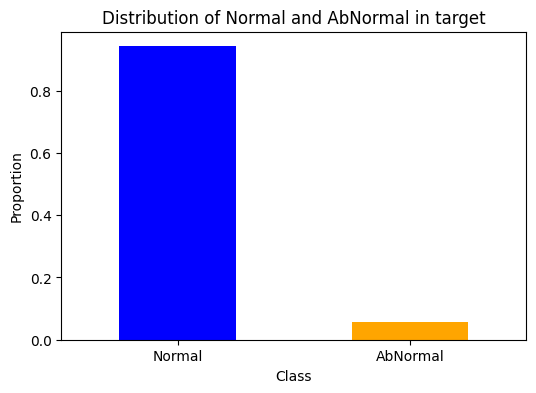

In [10]:

# Target distribution visualization
target_counts = train_data['target'].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
target_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Normal and AbNormal in target')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

## 데이터전처리

In [11]:

# Drop columns with common NaNs
nan_columns_train = train_data.columns[train_data.isna().any()].tolist()
nan_columns_test = test_data.columns[test_data.isna().any()].tolist()
common_nan_columns = list(set(nan_columns_train) & set(nan_columns_test))
train_data = train_data.drop(columns=common_nan_columns)
test_data = test_data.drop(columns=common_nan_columns)

# Split features and target
train_x = train_data.drop(columns=["target"])
train_y = train_data["target"]
test_x = test_data.drop(columns=["Set ID", "target"], errors='ignore')
test_set_id = test_data['Set ID']  # Save the Set ID column

# Separate numeric and categorical columns
numeric_cols = train_x.select_dtypes(include=['number']).columns
categorical_cols = train_x.select_dtypes(include=['object']).columns

# Fill missing values
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_x[numeric_cols] = numeric_imputer.fit_transform(train_x[numeric_cols])
test_x[numeric_cols] = numeric_imputer.transform(test_x[numeric_cols])
train_x[categorical_cols] = categorical_imputer.fit_transform(train_x[categorical_cols])
test_x[categorical_cols] = categorical_imputer.transform(test_x[categorical_cols])

# Encode categorical variables
def preprocess_data(df, categorical_cols):
    label_encoders = {}
    for column in categorical_cols:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df

train_x = preprocess_data(train_x, categorical_cols)
test_x = preprocess_data(test_x, categorical_cols)

# Scaling features
scaler = StandardScaler()
train_x = pd.DataFrame(scaler.fit_transform(train_x), columns=train_x.columns)
test_x = pd.DataFrame(scaler.transform(test_x), columns=test_x.columns)

In [13]:
# 예시: 'WorkMode_High' 피처 생성
# WorkMode Collect Result_Fill2 열을 기준으로 임계값을 설정해 높은 작업 모드인지 여부를 판단
# 임계값은 데이터 분포를 기반으로 설정 (여기서는 2.0을 임계값으로 가정)
train_x['WorkMode_High'] = train_x['WorkMode Collect Result_Fill2'] > 2.0
test_x['WorkMode_High'] = test_x['WorkMode Collect Result_Fill2'] > 2.0

# Boolean 값을 숫자로 변환
train_x['WorkMode_High'] = train_x['WorkMode_High'].astype(int)
test_x['WorkMode_High'] = test_x['WorkMode_High'].astype(int)


In [14]:
# Feature Engineering: Create a new combined feature
train_x['Combined_Factor'] = (
    train_x['Equipment_Dam'].astype(str) + '_' +
    train_x['Model.Suffix_Dam'].astype(str) + '_' +
    train_x['WorkMode_High'].astype(str)
)

test_x['Combined_Factor'] = (
    test_x['Equipment_Dam'].astype(str) + '_' +
    test_x['Model.Suffix_Dam'].astype(str) + '_' +
    test_x['WorkMode_High'].astype(str)
)

# Encode the new Combined_Factor feature
combined_factor_le = LabelEncoder()
train_x['Combined_Factor'] = combined_factor_le.fit_transform(train_x['Combined_Factor'])
test_x['Combined_Factor'] = combined_factor_le.transform(test_x['Combined_Factor'])

# Scaling features
scaler = StandardScaler()
train_x = pd.DataFrame(scaler.fit_transform(train_x), columns=train_x.columns)
test_x = pd.DataFrame(scaler.transform(test_x), columns=test_x.columns)


## 오버샘플링

In [15]:
# Balancing dataset using SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
train_x, train_y = smote.fit_resample(train_x, train_y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_x, train_y, test_size=0.3, stratify=train_y, random_state=RANDOM_STATE
)

In [ ]:
pip install imbalanced-learn

## 모델 정의

Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression F1 Score: 0.5900
              precision    recall  f1-score   support

    AbNormal       0.61      0.57      0.59     11447
      Normal       0.60      0.64      0.62     11447

    accuracy                           0.60     22894
   macro avg       0.60      0.60      0.60     22894
weighted avg       0.60      0.60      0.60     22894



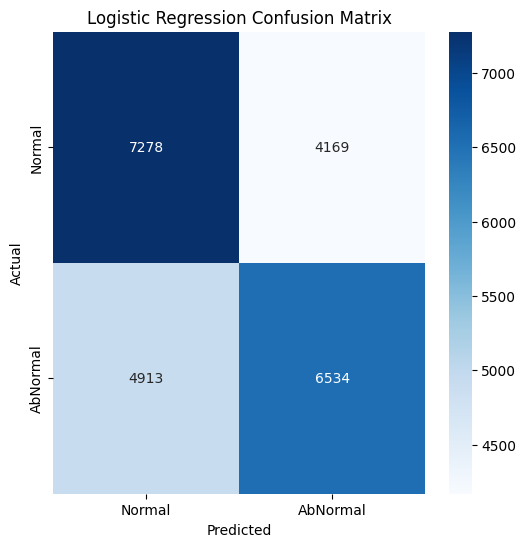

Training Random Forest...
Random Forest F1 Score: 0.9727
              precision    recall  f1-score   support

    AbNormal       0.99      0.95      0.97     11447
      Normal       0.96      0.99      0.97     11447

    accuracy                           0.97     22894
   macro avg       0.97      0.97      0.97     22894
weighted avg       0.97      0.97      0.97     22894



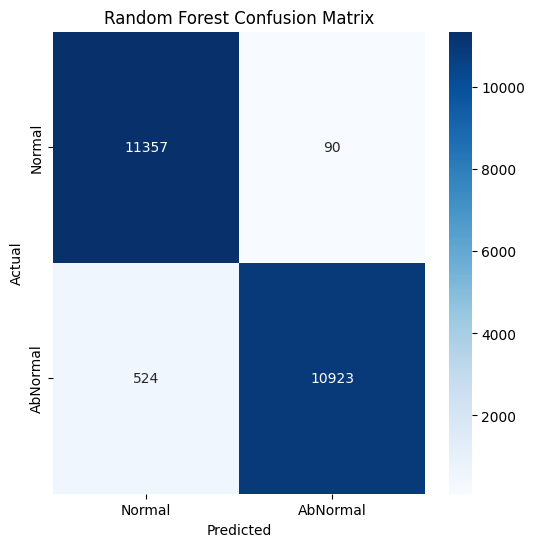

Training Gradient Boosting...
Gradient Boosting F1 Score: 0.8992
              precision    recall  f1-score   support

    AbNormal       1.00      0.82      0.90     11447
      Normal       0.85      1.00      0.92     11447

    accuracy                           0.91     22894
   macro avg       0.92      0.91      0.91     22894
weighted avg       0.92      0.91      0.91     22894



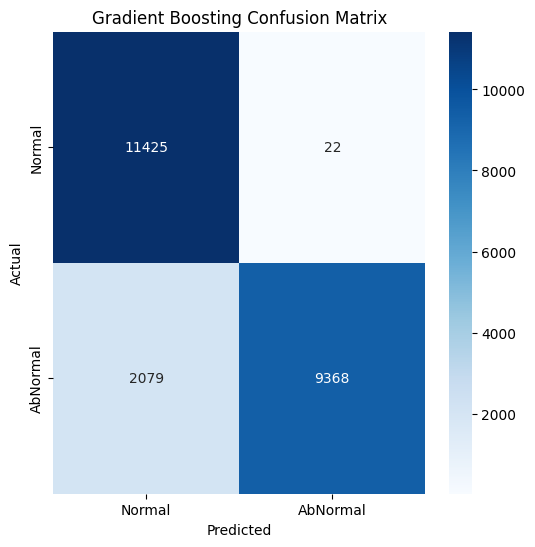

Training AdaBoost...
AdaBoost F1 Score: 0.8135
              precision    recall  f1-score   support

    AbNormal       0.86      0.77      0.81     11447
      Normal       0.79      0.87      0.83     11447

    accuracy                           0.82     22894
   macro avg       0.83      0.82      0.82     22894
weighted avg       0.83      0.82      0.82     22894



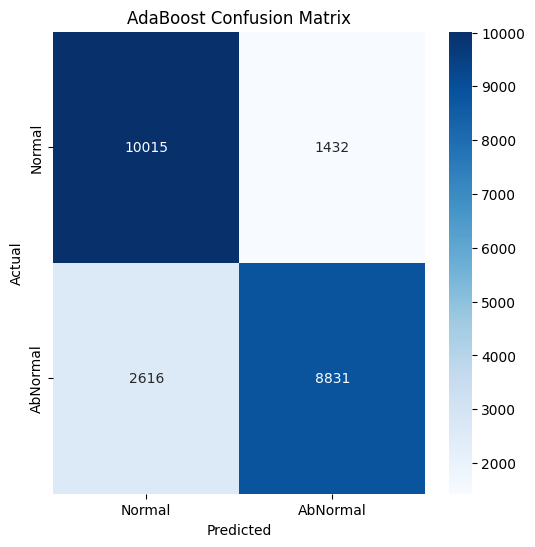

Training SVM...
SVM F1 Score: 0.6233
              precision    recall  f1-score   support

    AbNormal       0.64      0.61      0.62     11447
      Normal       0.63      0.66      0.64     11447

    accuracy                           0.63     22894
   macro avg       0.63      0.63      0.63     22894
weighted avg       0.63      0.63      0.63     22894



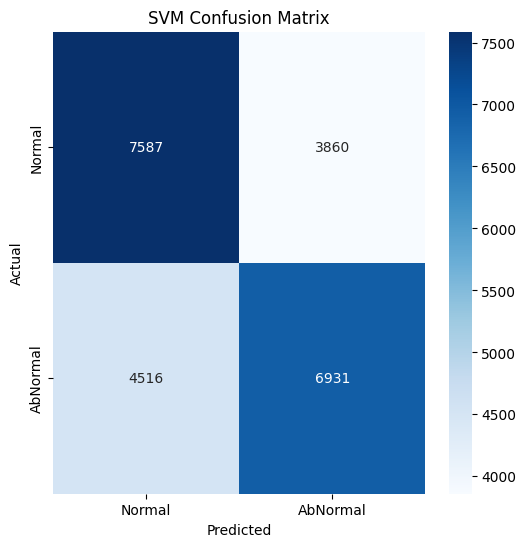

Training K-Nearest Neighbors...
K-Nearest Neighbors F1 Score: 0.8856
              precision    recall  f1-score   support

    AbNormal       0.82      0.96      0.89     11447
      Normal       0.95      0.79      0.86     11447

    accuracy                           0.88     22894
   macro avg       0.89      0.88      0.87     22894
weighted avg       0.89      0.88      0.87     22894



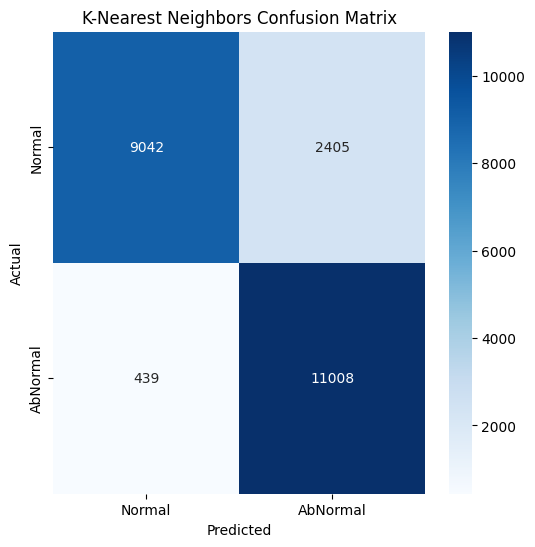

<ipython-input-9-b49a6a047668>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=performance_df, palette="viridis")


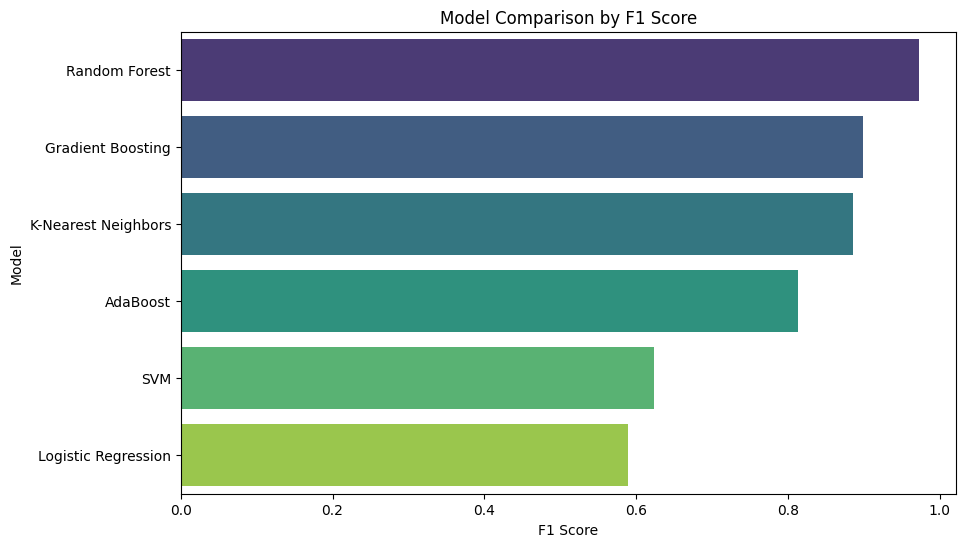

In [ ]:
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import classification_report, f1_score, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 사용할 모델 리스트 정의
# models = {
#     "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
#     "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
#     "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
#     "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
#     "SVM": SVC(random_state=RANDOM_STATE),
#     "K-Nearest Neighbors": KNeighborsClassifier(),
# }

# # 모델별 성능을 저장할 리스트 초기화
# model_performance = []

# # 각 모델에 대해 학습 및 평가 수행
# for model_name, model in models.items():
#     print(f"Training {model_name}...")
#     model.fit(X_train, y_train)
#     val_predictions = model.predict(X_val)

#     f1 = f1_score(y_val, val_predictions, pos_label="AbNormal")
#     model_performance.append({"Model": model_name, "F1 Score": f1})

#     print(f"{model_name} F1 Score: {f1:.4f}")
#     print(classification_report(y_val, val_predictions))

#     # Confusion Matrix 시각화
#     cm = confusion_matrix(y_val, val_predictions, labels=["Normal", "AbNormal"])
#     plt.figure(figsize=(6, 6))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "AbNormal"], yticklabels=["Normal", "AbNormal"])
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title(f"{model_name} Confusion Matrix")
#     plt.show()

# # 모델별 F1 점수 비교
# performance_df = pd.DataFrame(model_performance)
# performance_df = performance_df.sort_values(by="F1 Score", ascending=False)

# plt.figure(figsize=(10, 6))
# sns.barplot(x="F1 Score", y="Model", data=performance_df, palette="viridis")
# plt.title("Model Comparison by F1 Score")
# plt.show()

Voting Classifier F1 Score: 0.9683

Classification Report:
              precision    recall  f1-score   support

    AbNormal       0.97      0.97      0.97     11447
      Normal       0.97      0.97      0.97     11447

    accuracy                           0.97     22894
   macro avg       0.97      0.97      0.97     22894
weighted avg       0.97      0.97      0.97     22894



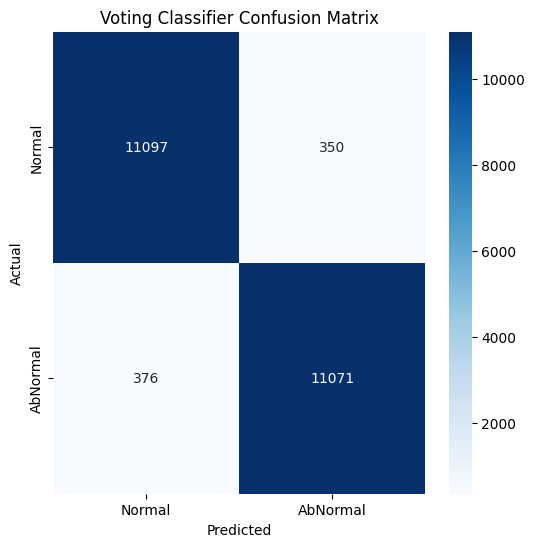

In [16]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest, Gradient Boosting, KNN 모델 정의
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
knn_model = KNeighborsClassifier()

# Voting Classifier 정의 (소프트 보팅 방식)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('gb', gb_model),
    ('knn', knn_model)
], voting='soft')  # 'soft' 보팅을 사용해 모델의 확률을 기반으로 예측

# 앙상블 모델 학습
voting_clf.fit(X_train, y_train)

# 검증 데이터로 예측 수행
val_predictions = voting_clf.predict(X_val)

# F1 Score 계산
f1 = f1_score(y_val, val_predictions, pos_label="AbNormal")
print(f"Voting Classifier F1 Score: {f1:.4f}")

# Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_val, val_predictions))

# Confusion Matrix 시각화
cm = confusion_matrix(y_val, val_predictions, labels=["Normal", "AbNormal"])
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "AbNormal"], yticklabels=["Normal", "AbNormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Voting Classifier Confusion Matrix")
plt.show()


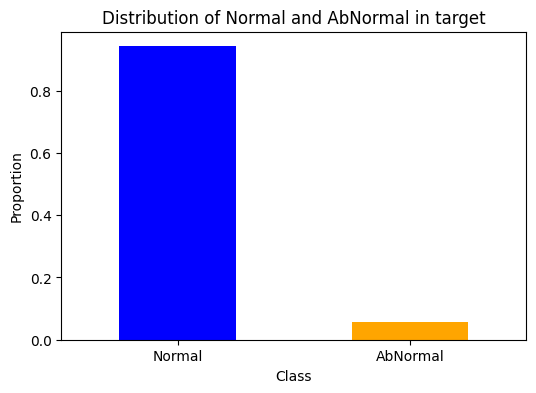

<ipython-input-18-5fcb22efa00d>:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_x['WorkMode_High'] = train_x['WorkMode Collect Result_Fill2'] > 2.0
<ipython-input-18-5fcb22efa00d>:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_x['WorkMode_High'] = test_x['WorkMode Collect Result_Fill2'] > 2.0
<ipython-input-18-5fcb22efa00d>:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

Voting Classifier F1 Score: 0.9682

Classification Report:
              precision    recall  f1-score   support

    AbNormal       0.97      0.97      0.97     11447
      Normal       0.97      0.97      0.97     11447

    accuracy                           0.97     22894
   macro avg       0.97      0.97      0.97     22894
weighted avg       0.97      0.97      0.97     22894



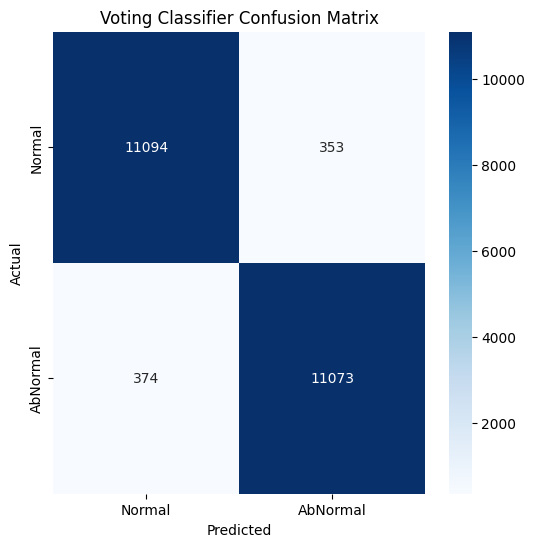

In [18]:
ROOT_DIR = "/content/drive/MyDrive/LG_AIMERS/data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

# Target distribution visualization
target_counts = train_data['target'].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
target_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Normal and AbNormal in target')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

# Drop columns with common NaNs
nan_columns_train = train_data.columns[train_data.isna().any()].tolist()
nan_columns_test = test_data.columns[test_data.isna().any()].tolist()
common_nan_columns = list(set(nan_columns_train) & set(nan_columns_test))
train_data = train_data.drop(columns=common_nan_columns)
test_data = test_data.drop(columns=common_nan_columns)

# Split features and target
train_x = train_data.drop(columns=["target"])
train_y = train_data["target"]
test_x = test_data.drop(columns=["Set ID", "target"], errors='ignore')
test_set_id = test_data['Set ID']  # Save the Set ID column

# Separate numeric and categorical columns
numeric_cols = train_x.select_dtypes(include=['number']).columns
categorical_cols = train_x.select_dtypes(include=['object']).columns

# Fill missing values
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_x[numeric_cols] = numeric_imputer.fit_transform(train_x[numeric_cols])
test_x[numeric_cols] = numeric_imputer.transform(test_x[numeric_cols])
train_x[categorical_cols] = categorical_imputer.fit_transform(train_x[categorical_cols])
test_x[categorical_cols] = categorical_imputer.transform(test_x[categorical_cols])

# Encode categorical variables
def preprocess_data(df, categorical_cols):
    label_encoders = {}
    for column in categorical_cols:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df

train_x = preprocess_data(train_x, categorical_cols)
test_x = preprocess_data(test_x, categorical_cols)

train_x['WorkMode_High'] = train_x['WorkMode Collect Result_Fill2'] > 2.0
test_x['WorkMode_High'] = test_x['WorkMode Collect Result_Fill2'] > 2.0

# Boolean 값을 숫자로 변환
train_x['WorkMode_High'] = train_x['WorkMode_High'].astype(int)
test_x['WorkMode_High'] = test_x['WorkMode_High'].astype(int)

# Feature Engineering: Create a new combined feature
train_x['Combined_Factor'] = (
    train_x['Equipment_Dam'].astype(str) + '_' +
    train_x['Model.Suffix_Dam'].astype(str) + '_' +
    train_x['WorkMode_High'].astype(str)
)

test_x['Combined_Factor'] = (
    test_x['Equipment_Dam'].astype(str) + '_' +
    test_x['Model.Suffix_Dam'].astype(str) + '_' +
    test_x['WorkMode_High'].astype(str)
)

# Encode the new Combined_Factor feature
combined_factor_le = LabelEncoder()
train_x['Combined_Factor'] = combined_factor_le.fit_transform(train_x['Combined_Factor'])
test_x['Combined_Factor'] = combined_factor_le.transform(test_x['Combined_Factor'])

# Scaling features
scaler = StandardScaler()
train_x = pd.DataFrame(scaler.fit_transform(train_x), columns=train_x.columns)
test_x = pd.DataFrame(scaler.transform(test_x), columns=test_x.columns)

# Balancing dataset using SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
train_x, train_y = smote.fit_resample(train_x, train_y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_x, train_y, test_size=0.3, stratify=train_y, random_state=RANDOM_STATE
)

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Random Forest, Gradient Boosting, KNN 모델 정의
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
knn_model = KNeighborsClassifier()

# Voting Classifier 정의 (소프트 보팅 방식)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('gb', gb_model),
    ('knn', knn_model)
], voting='soft')  # 'soft' 보팅을 사용해 모델의 확률을 기반으로 예측

# 앙상블 모델 학습
voting_clf.fit(X_train, y_train)

# 검증 데이터로 예측 수행
val_predictions = voting_clf.predict(X_val)

# F1 Score 계산
f1 = f1_score(y_val, val_predictions, pos_label="AbNormal")
print(f"Voting Classifier F1 Score: {f1:.4f}")

# Classification Report 출력
print("\nClassification Report:")
print(classification_report(y_val, val_predictions))

# Confusion Matrix 시각화
cm = confusion_matrix(y_val, val_predictions, labels=["Normal", "AbNormal"])
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "AbNormal"], yticklabels=["Normal", "AbNormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Voting Classifier Confusion Matrix")
plt.show()


F1 Score: 0.9727

Classification Report:
              precision    recall  f1-score   support

    AbNormal       0.99      0.95      0.97     11447
      Normal       0.96      0.99      0.97     11447

    accuracy                           0.97     22894
   macro avg       0.97      0.97      0.97     22894
weighted avg       0.97      0.97      0.97     22894



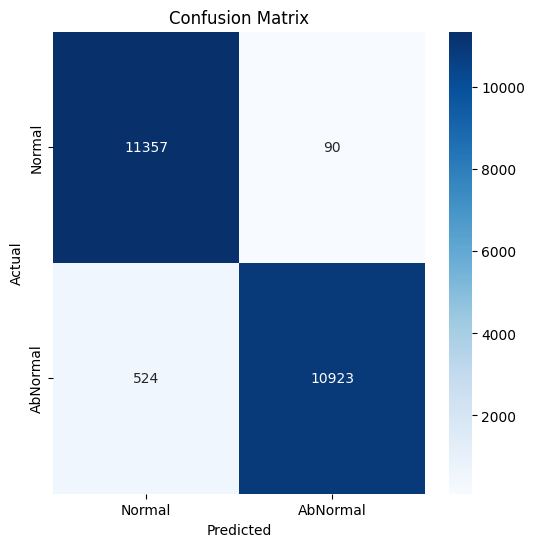

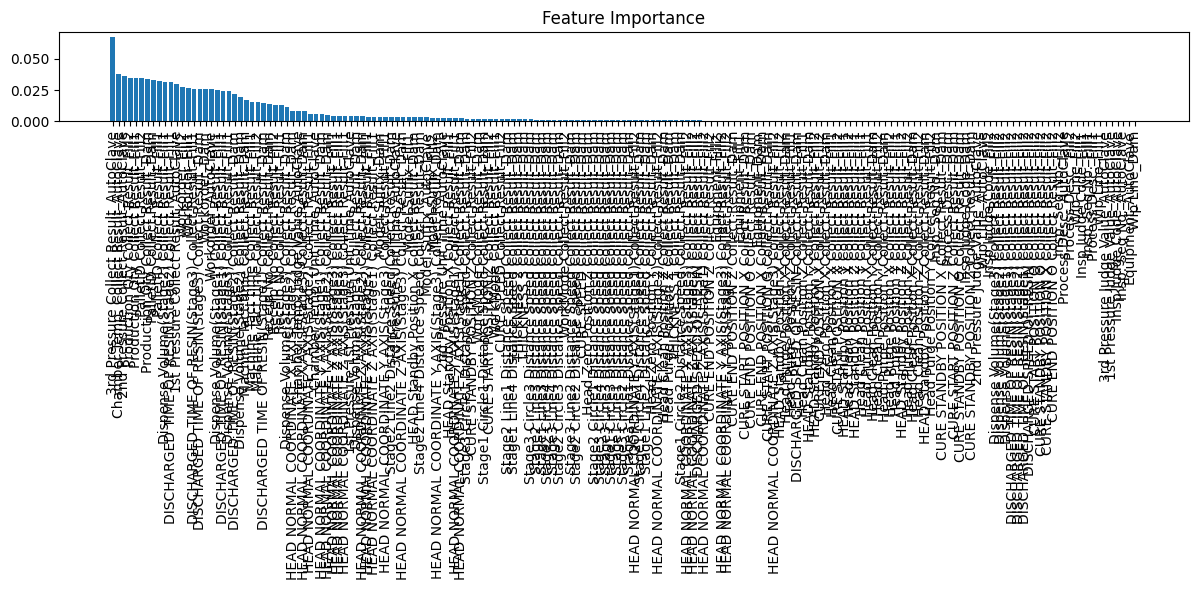

In [ ]:
# ### 모델 정의 및 학습
# model = RandomForestClassifier(random_state=RANDOM_STATE)
# model.fit(X_train, y_train)

# ### 모델 평가

# # Make predictions
# val_predictions = model.predict(X_val)

# # Evaluate the model
# f1 = f1_score(y_val, val_predictions, pos_label="AbNormal")
# print(f"F1 Score: {f1:.4f}")

# print("\nClassification Report:")
# print(classification_report(y_val, val_predictions))

# # Confusion Matrix 시각화
# cm = confusion_matrix(y_val, val_predictions, labels=["Normal", "AbNormal"])
# plt.figure(figsize=(6, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "AbNormal"], yticklabels=["Normal", "AbNormal"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# ### Feature Importance 시각화
# importances = model.feature_importances_
# indices = np.argsort(importances)[::-1]

# # Plot feature importances
# plt.figure(figsize=(12, 6))
# plt.title("Feature Importance")
# plt.bar(range(X_train.shape[1]), importances[indices], align="center")
# plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
# plt.tight_layout()
# plt.show()


In [ ]:

# ### 모델 정의 및 하이퍼파라미터 튜닝
# # RandomForest 하이퍼파라미터 튜닝
# rf_params = {
#     'n_estimators': [100, 300],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
# rf_grid = GridSearchCV(rf_model, rf_params, cv=StratifiedKFold(5), n_jobs=-1, scoring='f1', verbose=1)
# rf_grid.fit(X_train, y_train)

# print(f"Best RandomForest Parameters: {rf_grid.best_params_}")
# best_rf_model = rf_grid.best_estimator_

# # GradientBoosting 모델 정의
# gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE)

# # 앙상블 모델 (Voting Classifier) 정의
# ensemble_model = VotingClassifier(estimators=[
#     ('rf', best_rf_model),
#     ('gb', gb_model)
# ], voting='soft')

# # 모델 학습
# ensemble_model.fit(X_train, y_train)

# ### 모델 평가
# val_predictions = ensemble_model.predict(X_val)

# # Evaluate the model
# f1 = f1_score(y_val, val_predictions, pos_label="AbNormal")
# print(f"F1 Score: {f1:.4f}")

# print("\nClassification Report:")
# print(classification_report(y_val, val_predictions))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best RandomForest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
F1 Score: 0.9207

Classification Report:
              precision    recall  f1-score   support

    AbNormal       0.99      0.86      0.92     11447
      Normal       0.88      0.99      0.93     11447

    accuracy                           0.93     22894
   macro avg       0.93      0.93      0.93     22894
weighted avg       0.93      0.93      0.93     22894



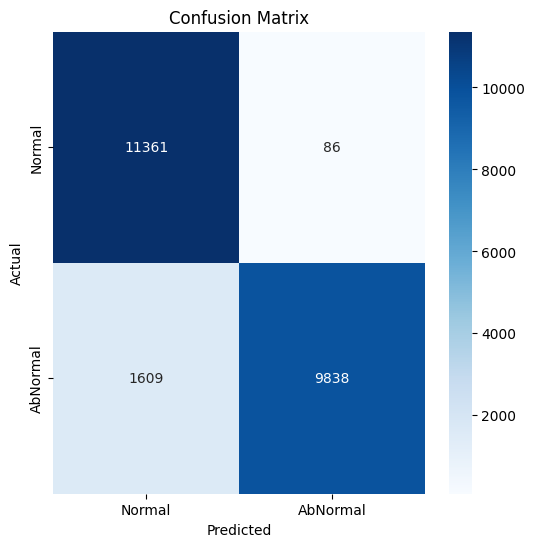

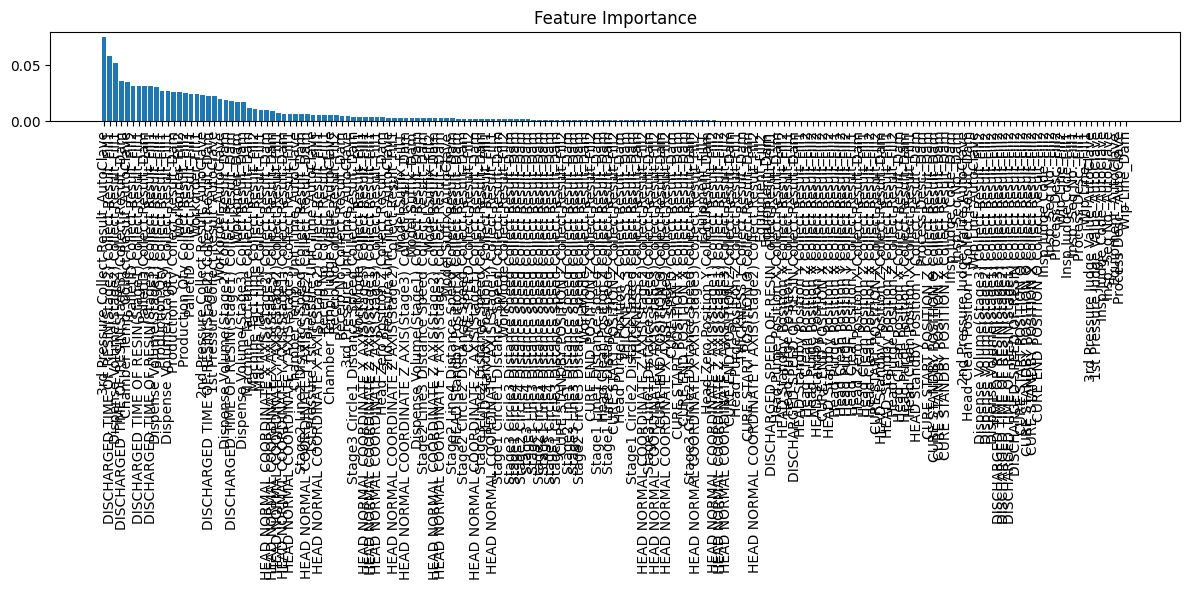

In [ ]:
# # Confusion Matrix 시각화
# cm = confusion_matrix(y_val, val_predictions, labels=["Normal", "AbNormal"])
# plt.figure(figsize=(6, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "AbNormal"], yticklabels=["Normal", "AbNormal"])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# ### Feature Importance 시각화 (RandomForest 기준)
# importances = best_rf_model.feature_importances_
# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(12, 6))
# plt.title("Feature Importance")
# plt.bar(range(X_train.shape[1]), importances[indices], align="center")
# plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
# plt.tight_layout()
# plt.show()

### 모델 정의


### 모델 학습


## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [ ]:
test_x

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,...,Head Clean Position Y Collect Result_Fill2,Head Clean Position Z Collect Result_Fill2,Head Purge Position X Collect Result_Fill2,Head Purge Position Y Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2
0,0.0,0.0,1.271748,-0.373781,-0.367676,0.0,0.0,1.271748,1.271748,1.271748,...,-1.209471,1.209471,1.209471,-1.209471,1.209471,-1.158578,-0.190863,1.154840,-0.823604,-0.598355
1,0.0,0.0,1.271748,-0.373781,1.100577,0.0,0.0,1.271748,1.271748,1.271748,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.745600,-0.566101,1.126588,0.177327
2,0.0,0.0,-0.786319,-0.373781,-0.978993,0.0,0.0,-0.786319,-0.786319,-0.786319,...,-1.209471,1.209471,1.209471,-1.209471,1.209471,-1.161320,-1.843447,0.232568,-0.823604,-0.598355
3,0.0,0.0,1.271748,-0.373781,-0.007435,0.0,0.0,1.271748,1.271748,1.271748,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.773143,-0.566101,-0.831251,0.177327
4,0.0,0.0,-0.786319,-0.373781,0.587507,0.0,0.0,-0.786319,-0.786319,-0.786319,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.745600,-0.689704,0.813027,0.177327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17356,0.0,0.0,1.271748,-0.373781,-0.165723,0.0,0.0,1.271748,1.271748,1.271748,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.704286,-0.566101,0.170612,0.177327
17357,0.0,0.0,1.271748,-0.373781,0.718504,0.0,0.0,1.271748,1.271748,1.271748,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.745600,-0.585117,1.302487,0.177327
17358,0.0,0.0,-0.786319,-0.373781,0.036230,0.0,0.0,-0.786319,-0.786319,-0.786319,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,0.629380,0.842001,-0.661180,-0.326496,0.177327
17359,0.0,0.0,-0.786319,-0.373781,-1.633975,0.0,0.0,-0.786319,-0.786319,-0.786319,...,-1.209471,1.209471,1.209471,-1.209471,1.209471,-1.183258,-1.843447,0.413219,-0.823604,-0.598355


### 제출 파일 작성


In [ ]:
# 테스트 데이터 예측 및 결과 저장
test_predictions = voting_clf.predict(test_x)

# 'Set ID' 열을 포함하여 결과를 저장
output = pd.DataFrame({'Set ID': test_set_id, 'Prediction': test_predictions})

# 'target' 열 추가
output["target"] = test_predictions

# 제출 파일 저장 (Set ID가 포함된 상태로 저장)
output.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
